# IGRINS GMTNIRS $76^{\circ}$ blaze model

LM3-10 maybe?

Here we finally get to our desired result: the blaze envelope at R3.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format='retina'

### Fixed physical properties

In [2]:
sigma = 71.43 # micron

In [3]:
groove_top_width = 71.43 - 42.43 # micron

In [4]:
blaze_angle_degrees = 76.2
blaze_angle_radians = np.radians(blaze_angle_degrees) # radians
blaze_angle_degrees

76.2

Assume testing in back-surface reflection in visible light!

In [5]:
wavelength_micron = 0.6328 # micron

In [6]:
beam_size_mm = 0.5 # mm
beam_size_micron = beam_size_mm*1000.0

Fix the angle of incidence for now.

### Set the angular sampling

We want a number that has about 10 steps per beamsize.

In [7]:
degrees_per_step = 0.002 # degrees

In [8]:
angular_grid_degrees = np.arange(-90, 90, degrees_per_step)
angular_grid_radians = np.radians(angular_grid_degrees)

In [9]:
max_m = np.floor(2 * sigma / wavelength_micron)
m_vector = np.arange(-max_m, max_m+1, 1)

Note that we are including diffraction orders like $m=-52$ that only exist for some incidence angles.  That's OK! We are being overly-inclusive in case we go to extreme values of $\theta_i$ that reveal some of those presently-unphysical orders.

### Calculate the groove scarp facet diffraction

Compute the angles of the peak of diffraction for the input wavelength.  

Grating equation:

$\sin{\theta_m} = \left( \sin\theta_i -\frac{m\lambda}{\sigma}\right )$  

Which is also:

$\theta_m = \arcsin{\left( \sin\theta_i -\frac{m\lambda}{\sigma}\right )}$  

But, if you are "In Littrow", that means $\alpha=\beta=\delta$:


$2\sin{\delta} = \frac{m\lambda}{\sigma}$  

Which is:

$\delta = \arcsin{\frac{m\lambda}{2\sigma}}$  

In [67]:
targetm = 220

In [68]:
theta_i_radians = np.arcsin((targetm*wavelength_micron)/(2*sigma))
theta_i_degrees = np.degrees(theta_i_radians)

In [69]:
theta_i_degrees

77.03122409410736

In [70]:
%%capture
theta_m_radians = np.arcsin(np.sin(theta_i_radians) - m_vector*(wavelength_micron)/sigma)
theta_m_degrees = np.degrees(theta_m_radians)

In [71]:
finite_mask = np.isfinite(theta_m_radians)

In [72]:
theta_m_column = theta_m_radians[np.newaxis, :]

### Visualize the unblazed diffraction from all of these orders

We need to shift-and-sum the flux contribution from all of our diffraction orders.

Each order has a mirror-like diffraction centered on its $\theta_m$:

$$\frac{I_m(\boldsymbol{\theta})}{I_0} = \operatorname{sinc}^2 \left[ \frac{d \pi}{\lambda} \sin{(\boldsymbol{\theta}-\theta_m)}\right]$$

$$\mathrm{"LHS"} = \mathrm{"RHS"}$$

In [73]:
rhs_argument = (beam_size_micron*np.pi/(wavelength_micron)*
                np.sin(angular_grid_radians[:, np.newaxis]-theta_m_column))

There's technically a foreshortening term associated with non-normal-incidence beamsize projection effects.   
Ignore it for now!

$$\frac{I(\boldsymbol{\theta})}{I_0} = \sum_{m_\mathrm{min}}^{m_\mathrm{max}} \operatorname{sinc}^2 \left[ \frac{d \pi}{\lambda} \sin{(\boldsymbol{\theta}-\theta_m)}\right]$$

In [74]:
rhs = np.nan_to_num(np.sinc(rhs_argument)**2, nan=0.0)

In [75]:
unblazed_groove_top_diffraction = np.sum(rhs, axis=1)

### Visualize the *blazed* diffraction from all of these orders

Each order has a mirror-like diffraction centered on its $\theta_m$, calculated above.

In [76]:
def foreshortened_groove(sigma, groove_top_width, incidence_angle):
    """ The size of the illuminated groove 
    
    Note:
    -----
    Function formerly known as "beam_waist", renamed to disambiguate
    
    Parameters:
    -----------
    sigma: The groove spacing or groove pitch (micron)
    groove_top_width: The groove top or 'dam' unique to Si grating
        development, they cause shadowing (micron)
    incidence_angle: The input angle, as measured from the 
        grating normal (degrees)
    """
    
    A_micron = sigma - groove_top_width
    incidence_angle_radians = np.radians(incidence_angle)
    
    output = A_micron * np.cos(incidence_angle_radians)
    return output

In [77]:
d_term = foreshortened_groove(sigma, groove_top_width, theta_i_degrees)
d_term

9.522141664620843

In [78]:
blaze_modulation = np.sinc((d_term*np.pi/(wavelength_micron)*
                np.sin(angular_grid_radians + blaze_angle_radians)))**2

## Aside: a simple table of the expected brightnesses

We are getting towards a nice plot, but on the way, what we really care about is a simple table of the order numbers and the fluxes of those orders. And we want to focus on the brightest few (~3) orders.

In [79]:
blaze_modulation_at_order_peaks = np.sinc((d_term*np.pi/(wavelength_micron)*
                np.sin(theta_m_radians + blaze_angle_radians)))**2

In [80]:
import pandas as pd

In [95]:
lookup_dict = {'m':m_vector, 
               'theta_i_degrees':theta_i_degrees*(-1),
               'theta_m_degrees':theta_m_degrees, 
               'theta_m_radians':theta_m_radians,
               'unnormalized_flux':blaze_modulation_at_order_peaks,
               'normalize_flux':blaze_modulation_at_order_peaks/np.nanmax(blaze_modulation_at_order_peaks)
              }

In [96]:
df = pd.DataFrame(lookup_dict).dropna()

In [97]:
pd.set_option('display.max_rows', 300)

In [98]:
brightest_index = df.normalize_flux.argmax()

In [101]:
df.iloc[brightest_index-3:brightest_index+1]

,m,theta_i_degrees,theta_m_degrees,theta_m_radians,unnormalized_flux,normalize_flux
442,217.0,-77.031224,-71.426430,-1.246626,0.000277,0.001849
443,218.0,-77.031224,-73.092291,-1.275701,0.014832,0.098887
444,219.0,-77.031224,-74.935420,-1.307870,0.001711,0.011410
445,220.0,-77.031224,-77.031224,-1.344448,0.149995,1.000000


Again, there's an incidence-angle foreshortening effect here...

(-90, -60)

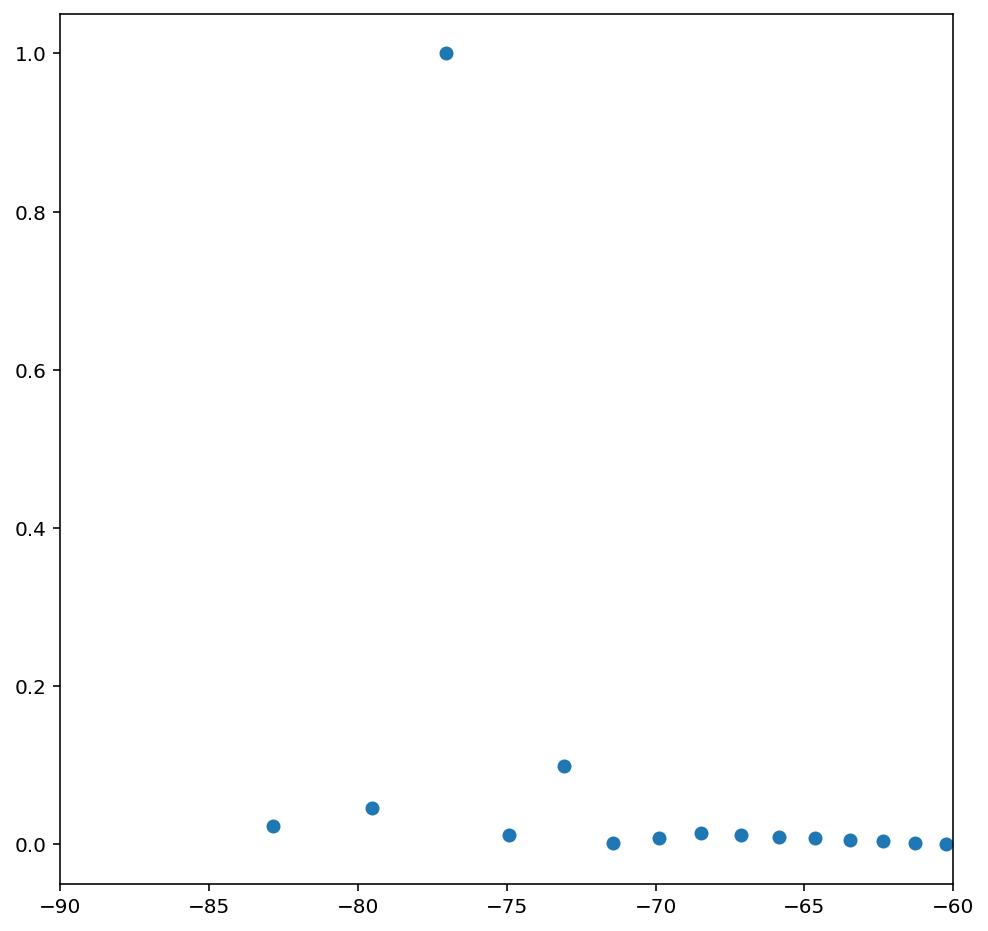

In [86]:
plt.figure(figsize=(8, 8))
plt.plot(df['theta_m_degrees'], df['normalize_flux'], 'o')
plt.xlim(-90, -60)

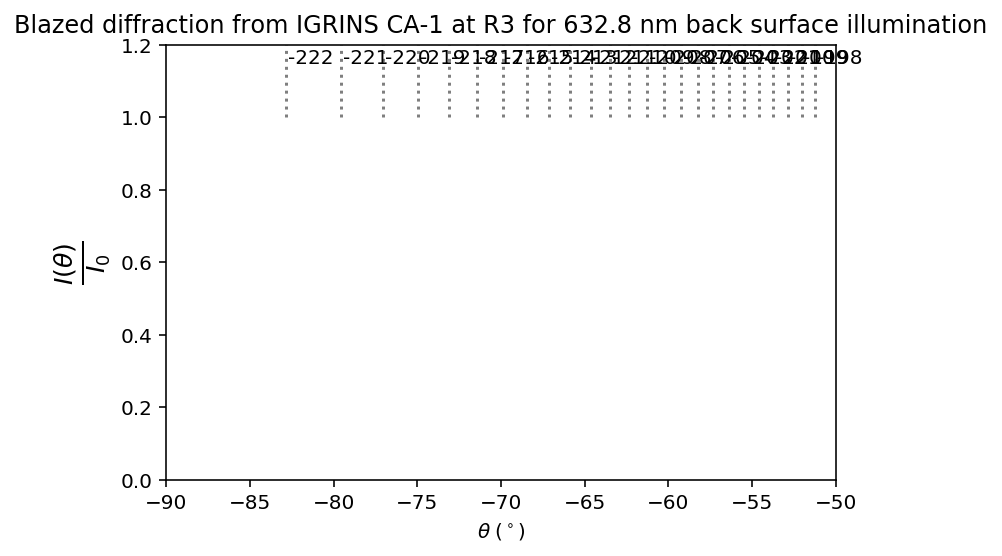

In [87]:
x_lo, x_hi = (-90, -50)
plt.xlim(x_lo, x_hi)
plt.ylim(0, 1.2)

for m, theta_m in zip(m_vector, theta_m_degrees):
    if np.isfinite(theta_m) & (theta_m>x_lo) & (theta_m < x_hi-1):
        plt.text(theta_m+0.1, 1.15, "{:d}".format(-int(m)), rotation='horizontal')
        plt.plot([theta_m, theta_m], [1.0, 1.2], color='k', alpha=0.5, 
                 linestyle='dotted')

#plt.text(-77, 0.8, ratio)
plt.xlabel(r'$\theta \; (^\circ)$')
plt.ylabel(r'$\frac{I(\theta)}{I_0}$', fontsize=18)
plt.title('Blazed diffraction from IGRINS CA-1 at R3 for 632.8 nm back surface illumination'.format(beam_size_mm) );

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

plt.savefig('../../figures/GMTNIRS_76_blaze_demo.png', dpi=300, bbox_inches='tight');

## For display purposes:
Show the blaze envelope.

In [88]:
blazed_groove_top_diffraction = blaze_modulation * unblazed_groove_top_diffraction

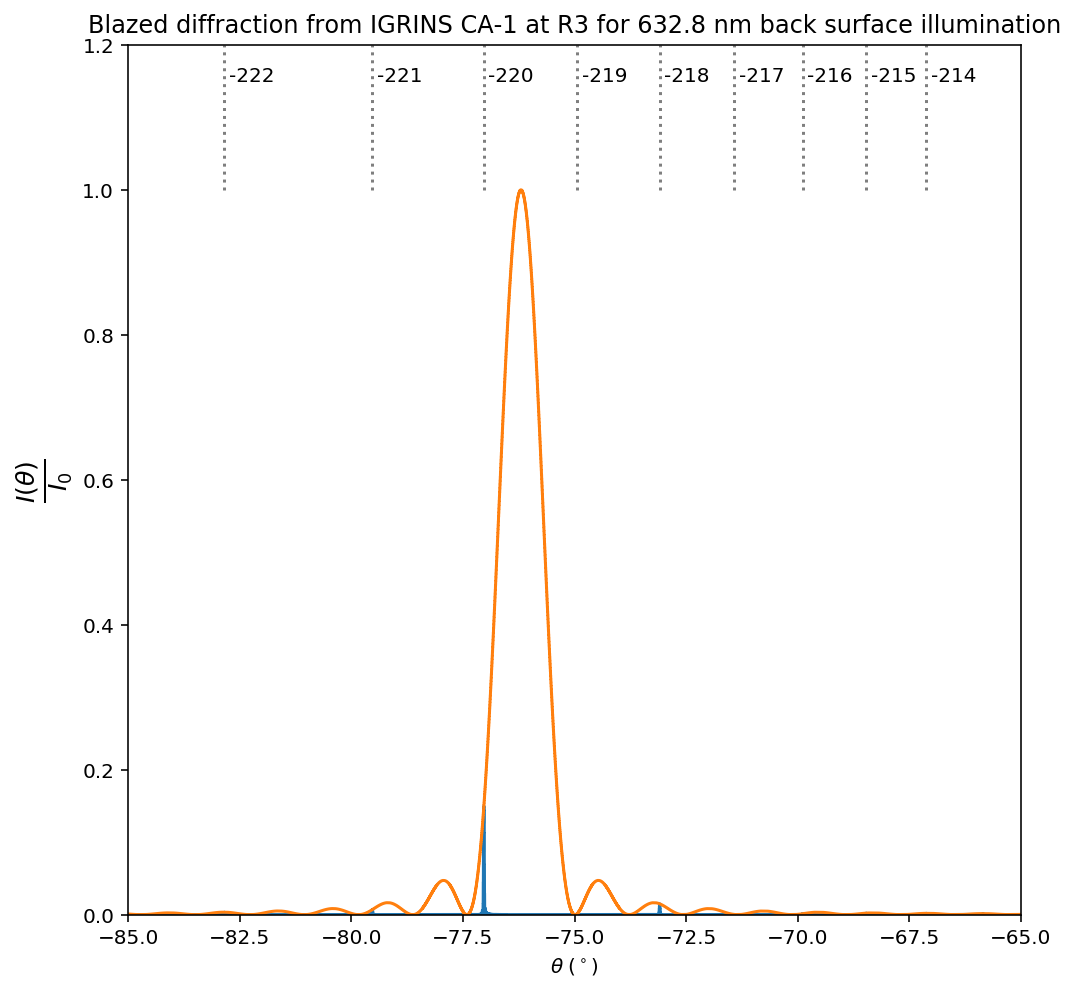

In [89]:
plt.figure(figsize=(8, 8))
plt.step(angular_grid_degrees, blazed_groove_top_diffraction, where='mid')
plt.step(angular_grid_degrees, blaze_modulation, where='mid')

x_lo, x_hi = (-85, -65)
plt.xlim(x_lo, x_hi)
plt.ylim(0, 1.2)

for m, theta_m in zip(m_vector, theta_m_degrees):
    if np.isfinite(theta_m) & (theta_m>x_lo) & (theta_m < x_hi-1):
        plt.text(theta_m+0.1, 1.15, "{:d}".format(-int(m)), rotation='horizontal')
        plt.plot([theta_m, theta_m], [1.0, 1.2], color='k', alpha=0.5, 
                 linestyle='dotted')

#plt.text(-77, 0.8, ratio)
plt.xlabel(r'$\theta \; (^\circ)$')
plt.ylabel(r'$\frac{I(\theta)}{I_0}$', fontsize=18)
plt.title('Blazed diffraction from IGRINS CA-1 at R3 for 632.8 nm back surface illumination'.format(beam_size_mm) );

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

plt.savefig('../../figures/GMTNIRS_76_blaze_demo.png', dpi=300, bbox_inches='tight');

Let's look at the whole range in log space

In [ ]:
plt.figure(figsize=(14, 4))
plt.step(angular_grid_degrees, blazed_groove_top_diffraction)
plt.step(angular_grid_degrees, blaze_modulation)

x_lo, x_hi = (-90, -50)
plt.xlim(x_lo, x_hi)
plt.ylim(1e-4, 2)
plt.yscale('log')

for m, theta_m in zip(m_vector, theta_m_degrees):
    if np.isfinite(theta_m) & (theta_m>x_lo) & (theta_m < x_hi) & (np.mod(m, 1) ==0):
        plt.text(theta_m+0.1, 1.15, "{:d}".format(-int(m)), rotation='horizontal')
        plt.plot([theta_m, theta_m], [0.01, 1.2], color='k', alpha=0.5, 
                 linestyle='dotted')

plt.xlabel(r'$\theta \; (^\circ)$')
plt.ylabel(r'$\frac{I(\theta)}{I_0}$', fontsize=18)
plt.title('Blazed diffraction from IGRINS groove tops'.format(beam_size_mm) );

Awesome!  Appears correct!